# Artist Identification

In [2]:
# Plotting
from matplotlib.colors import ListedColormap

# Preprocessing and metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import multilabel_confusion_matrix
import time

# Classifiers 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel


# Dimensionality reduction libraries
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn import manifold, datasets, decomposition, discriminant_analysis

#Other libraries 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import pickle
from joblib import dump, load
import json
import os

#Load DIP modules
import glob
import dippykit as dip

In [3]:
%matplotlib inline

# Feature Extraction

### Importing extracted and saved features

In [4]:
import pickle

hu_moments_list_tuple = pd.read_pickle( "Feature Extraction/Hu Moments.pkl") 
histograms_list_tuple = pd.read_pickle( "Feature Extraction/Color Histograms.pkl" ) 
hog_list_tuple = pd.read_pickle( "Feature Extraction/HOGs Resized.pkl") 
lbp_list_tuple = pd.read_pickle( "Feature Extraction/Resized_LPBs.pkl" ) 
sift_list_tuple = pd.read_pickle( "Feature Extraction/SIFTs.pkl" ) 


### Converting artist names to labels

In [5]:
type([x[1] for x in histograms_list_tuple])
names = [x[1] for x in histograms_list_tuple]
d = {ni: indi for indi, ni in enumerate(set(names))}
y = np.array([d[ni] for ni in names])
print("Training set details:")
print("Artist-label map:", d)
print("Total number of images:",y.shape[0])
print("Diego:",y[y==0].shape[0])
print("Rembrandt:",y[y==1].shape[0])
print("Caravaggio:",y[y==2].shape[0])
print("Peter:",y[y==3].shape[0])

Training set details:
Artist-label map: {'Diego': 0, 'Peter': 1, 'Rembrandt': 2, 'Caravaggio': 3}
Total number of images: 586
Diego: 128
Rembrandt: 141
Caravaggio: 262
Peter: 55


In [6]:
hu_moments = np.squeeze(np.array([x[2] for x in hu_moments_list_tuple]))
histograms = np.reshape(np.squeeze(np.array([x[2] for x in histograms_list_tuple])),(len(hu_moments_list_tuple),-1))
hog = np.squeeze(np.array([x[2] for x in hog_list_tuple]))
lbp = np.reshape(np.squeeze(np.array([x[2] for x in lbp_list_tuple])),(len(hu_moments_list_tuple),-1))
sift = np.squeeze([i[:20,:] for i in [x[2] for x in sift_list_tuple]]).reshape(586,2560)

# Feature dimensions
print("(Number of images, Number of features)")
print("Hu Moments:",hu_moments.shape)
print("Histograms:",histograms.shape)
print("HoG:",hog.shape)
# print("LBP:",lbp.shape)
print("SIFT:",sift.shape)

(Number of images, Number of features)
Hu Moments: (586, 7)
Histograms: (586, 768)
HoG: (586, 3600)
SIFT: (586, 2560)


In [7]:
# datasets = [(hu_moments,y), (histograms,y), (hog,y),(sift,y)]
datasets = [(histograms,y), (hog,y),(sift,y)]
# datasets = [(hu_moments,y)]

In [8]:
y.shape


(586,)

# Dimensionality reduction

In [9]:
# Dimensionality reduction algorithms
dr_names = ["kpca","lda","tsne"]

In [10]:
# Apply dimensionality reduction to the dataset

def dim_red(X, y, best_params):
#     {'reduce_dim': KernelPCA(kernel='rbf', n_components=4), 'reduce_dim__kernel': 'rbf', 'reduce_dim__n_components': 4}
    dr = best_params['reduce_dim']
    
    X_dr = dr.fit_transform(X, y)
    
    return X_dr

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin #gives fit_transform method for free
#Since TSNE does not have a transform method
class tSNE(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.model = TSNE(n_components)
    
    def fit(self, X, y=None):
#         self.model.fit(X)
        return self
    
    def transform(self, X, y=None):
        return self.model.fit_transform(X)

# Visualization of Dimensionality Reduction Results

In [17]:
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Visualize results for different classifiers after dimensionality reduction using kPCA

def tune_clf_viz(X_train, y_train, parameters, num_fold, clf_name):
    
    # Define the pipeline
    pipe = Pipeline([
        ('reduce_dim', KernelPCA()),
        ('classify', KNeighborsClassifier(3))
    ])

    # Use kFold CV for evaluating the pipeline
    kf = KFold(n_splits = num_fold, shuffle = False)
    
    # Define the paramters to search over for dimensionality reduction
    N_FEATURES_OPTIONS = range(1,220,10)    
    
    param_grid = [
            {
                'reduce_dim': [KernelPCA(kernel = 'rbf')],
                'reduce_dim__n_components': N_FEATURES_OPTIONS,
            },
        ]
    
    i = 0
    if clf_name == "Nearest Neighbors":
        param_grid[i]['classify'] = [KNeighborsClassifier(n_neighbors = 8)]

    if clf_name == "Logistic Regression":
        param_grid[i]['classify'] = [LogisticRegression(max_iter = 10000)]

    if clf_name == "SVM":
        param_grid[i]['classify'] = [SVC(max_iter = 100000)]

    if clf_name == "Decision Tree":
        param_grid[i]['classify'] = [DecisionTreeClassifier()]

    if clf_name == "Random Forest":
        param_grid[i]['classify'] = [RandomForestClassifier()]
        
    if clf_name == "Gaussian Process":
        param_grid[i]['classify'] = [GaussianProcessClassifier()]

    if clf_name == "Neural Net":
        param_grid[i]['classify'] = [MLPClassifier(alpha=1, max_iter=1000)]

    if clf_name == "Adaboost":
        param_grid[i]['classify'] = [AdaBoostClassifier()]

    if clf_name == "Naive Bayes":
        param_grid[i]['classify'] =  [GaussianNB()]

    if clf_name == "QDA":
        param_grid[i]['classify'] = [QuadraticDiscriminantAnalysis()]

    grid = GridSearchCV(pipe, cv=kf, n_jobs=6, param_grid=param_grid, scoring='accuracy')
#     grid = RandomizedSearchCV(pipe, cv=kf, n_jobs=6, param_distributions=param_grid, scoring='accuracy')
    grid.fit(X_train, y_train)

    mean_scores = np.array(grid.cv_results_['mean_test_score'])
    acc = np.max(mean_scores)
#     print(acc)
    best_params = grid.best_params_
    return mean_scores, best_params

Accuracy vs Number of features (log scale) for randomly chosen subsets of the dataset
Nearest Neighbors


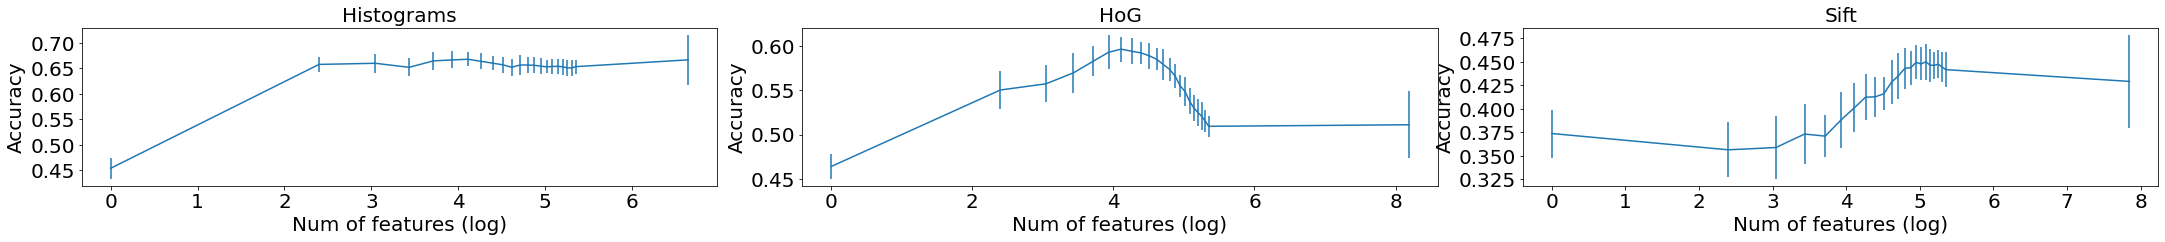

Logistic Regression


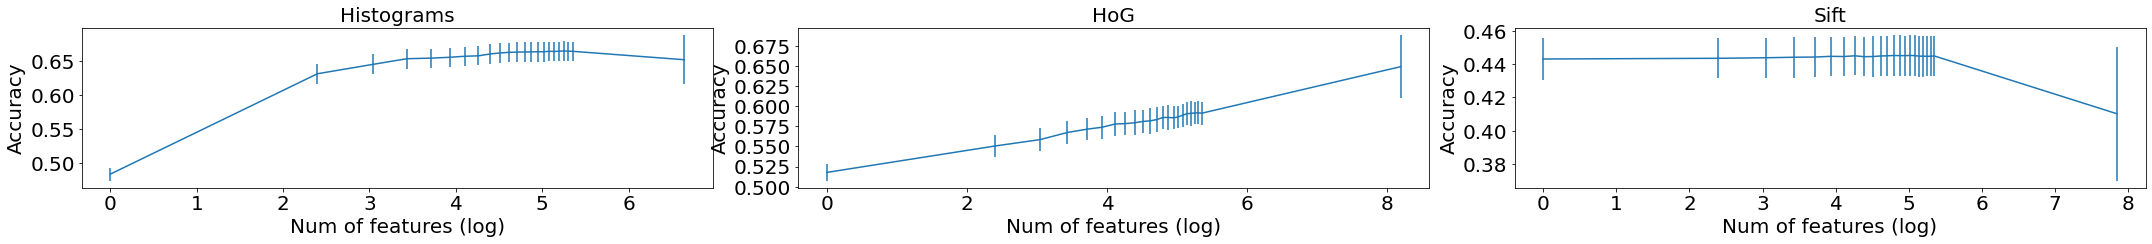

SVM


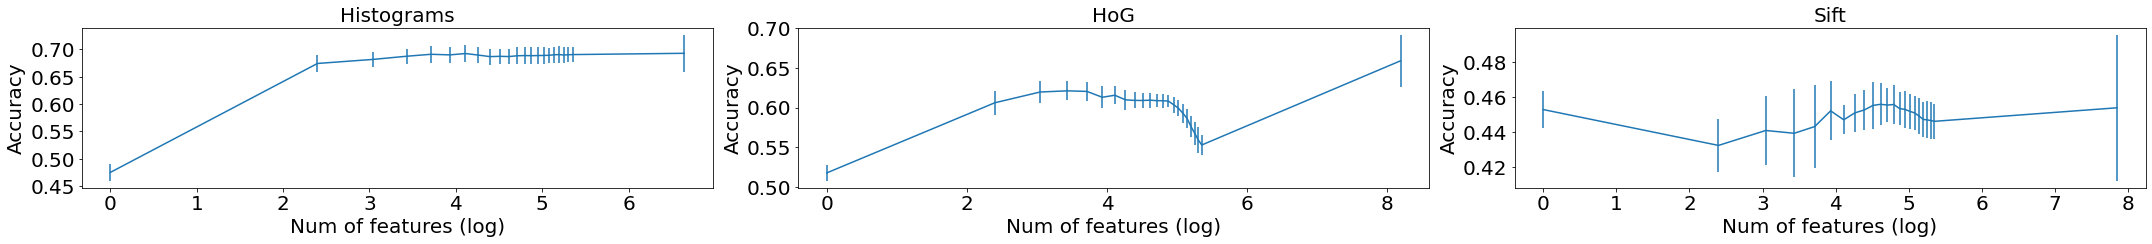

Gaussian Process


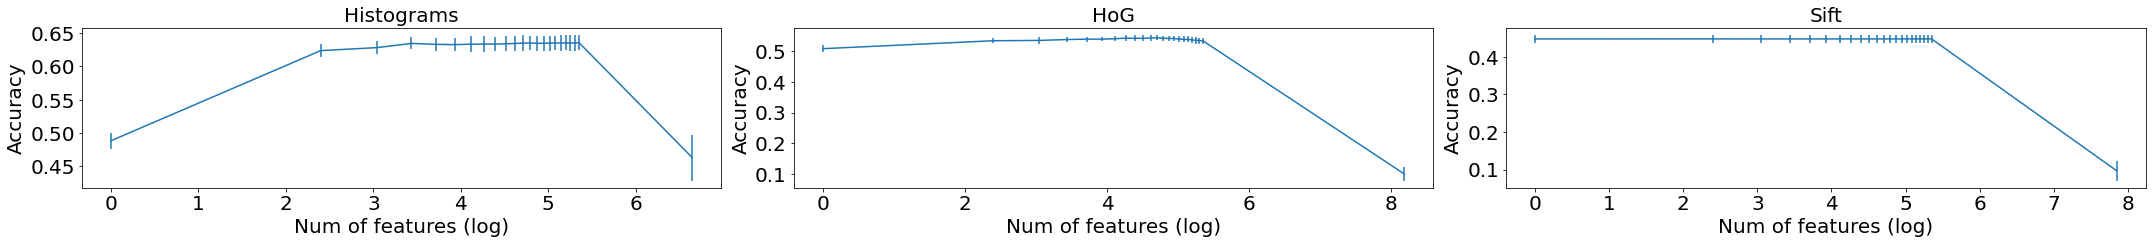

Decision Tree


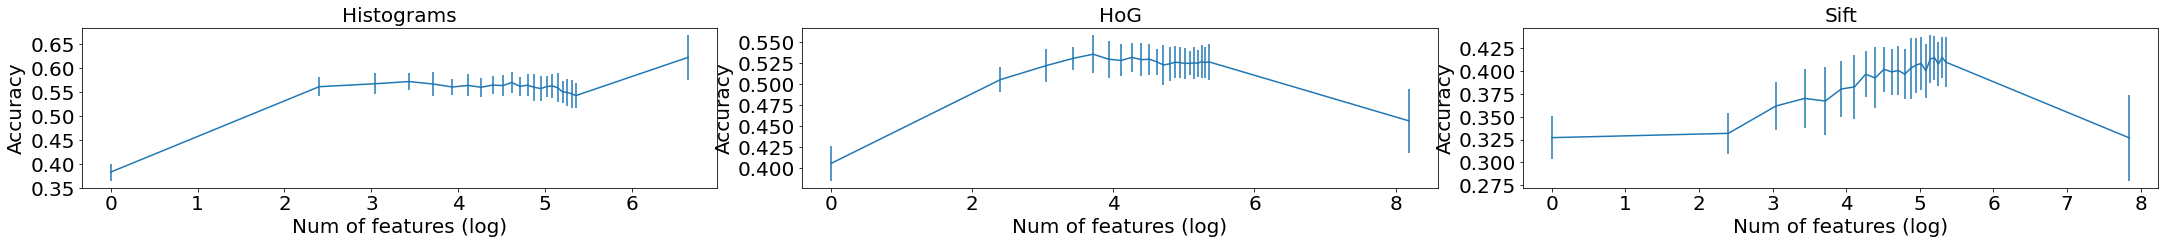

Random Forest


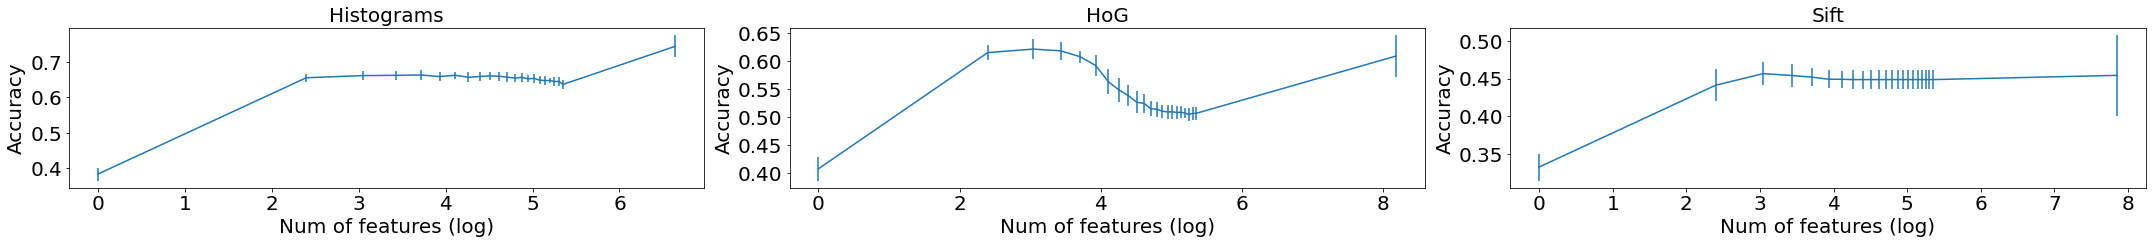

Neural Net


C:\Users\sc699\miniconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


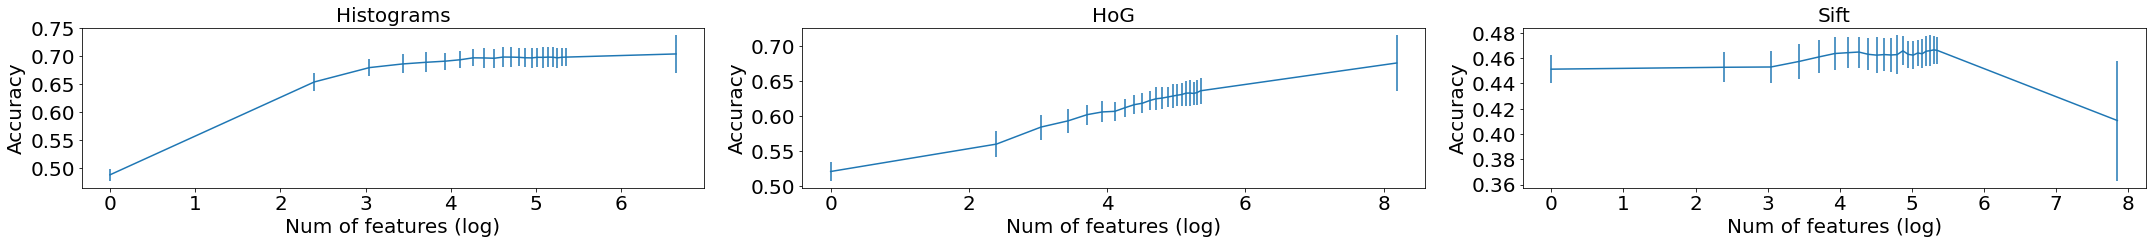

AdaBoost


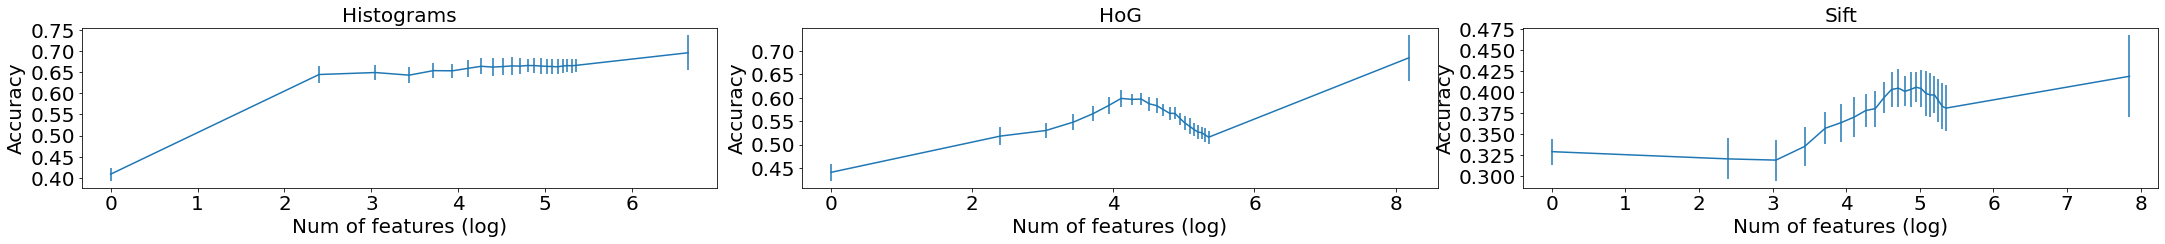

Naive Bayes


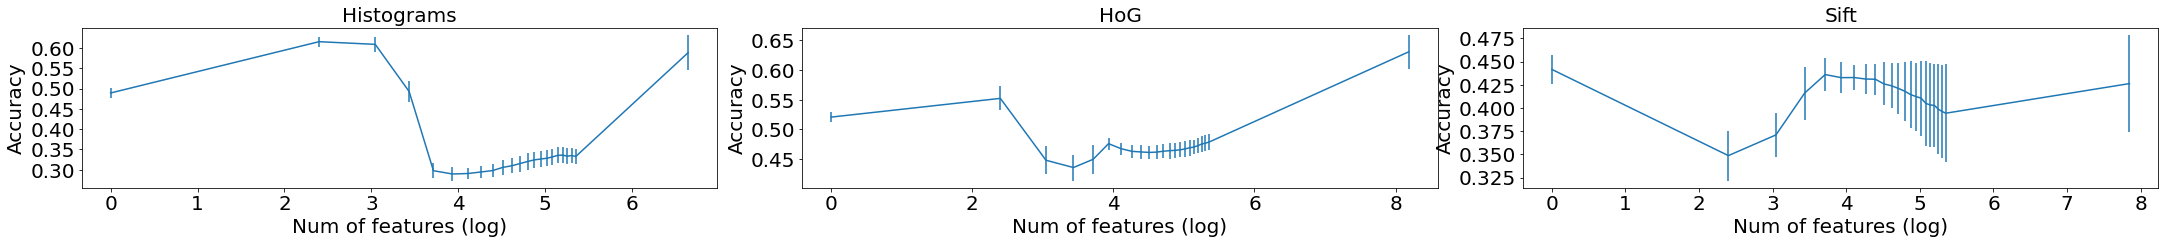

QDA


C:\Users\sc699\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\sc699\miniconda3\li

C:\Users\sc699\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\sc699\miniconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\sc699\miniconda3\li

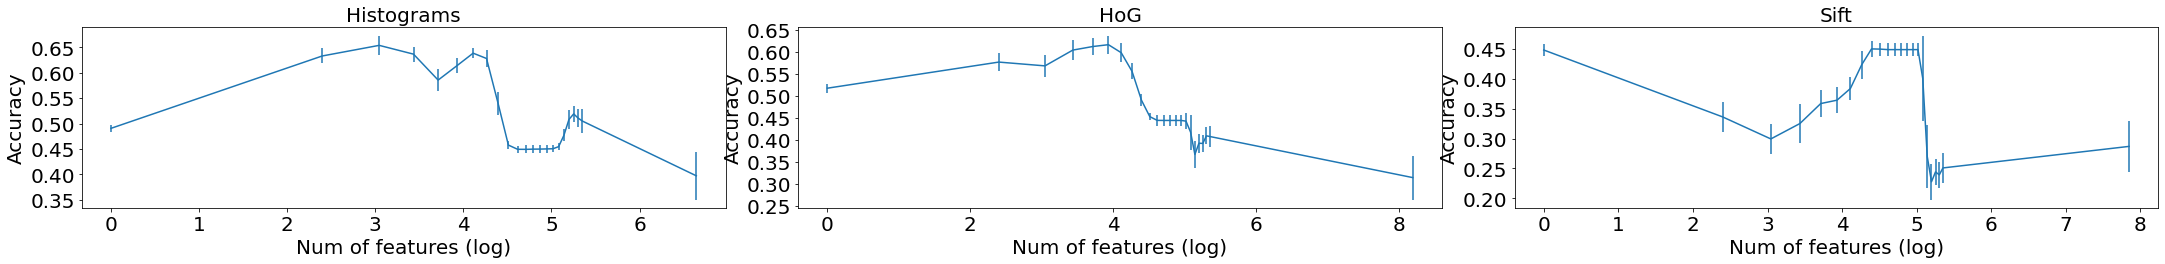

In [18]:
from sklearn.metrics import accuracy_score

classifier_names = ["Nearest Neighbors", 
                    "Logistic Regression",
                    "SVM",
                    "Gaussian Process",
                    "Decision Tree", 
                    "Random Forest", 
                    "Neural Net",
                    "AdaBoost",
                    "Naive Bayes", 
                    "QDA"]


ds_names = ['Histograms','HoG','Sift']

im_count = 1
print("Accuracy vs Number of features (log scale) for randomly chosen subsets of the dataset")

# Iterate through the classifiers

for name in classifier_names:
# for name in ["Nearest Neighbors"]:
    print(name)
    figure = plt.figure(figsize=(30, 30))
    # Iterate over datasets
    for ds_cnt, ds in enumerate(datasets):
        X, y = ds
        X = StandardScaler().fit_transform(X)
        ax = plt.subplot(len(classifier_names),len(datasets),im_count)

        acc_avg = []
        
        # Average over 20 random iterations
        for i in range(20):

            # Preprocess dataset, split into training and test part
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
            n_train = X_train.shape[0]

            # Find the CV accuracies for the classifier and dim. red. algorithm        
            mean_scores, best_params = tune_clf_viz(X_train, y_train, [] , 5, name)

            if name == "Nearest Neighbors":
                clf = KNeighborsClassifier(n_neighbors = 8)

            if name == "Logistic Regression":
                 clf = LogisticRegression(max_iter = 10000)

            if name == "SVM":
                clf = SVC(max_iter = 100000)

            if name == "Decision Tree":
                clf = DecisionTreeClassifier()

            if name == "Random Forest":
                clf = RandomForestClassifier()
                
            if name == "Gaussian Process":
                clf = GaussianProcessClassifier()

            if name == "Neural Net":
                clf = MLPClassifier(alpha=1, max_iter=1000)

            if name == "Adaboost":
                clf = AdaBoostClassifier()
                
            if name == "Naive Bayes":
                clf =  GaussianNB()

            if name == "QDA":
                clf = QuadraticDiscriminantAnalysis()


            clf.fit(X_train, y_train)
            mean_scores =list(mean_scores)
            mean_scores.append(accuracy_score(y_test, clf.predict(X_test)))
            acc_avg.append(mean_scores)

        # Plot the accuracies vs the number of dimensions
        ax_x = [i for i in range(1,220,10)]
        ax_x.append(X_train.shape[1])
        ax.errorbar(np.log(ax_x), np.mean(np.array(acc_avg), axis=0), np.std(np.array(acc_avg), axis=0))
        
        ax.set_xlabel('Num of features (log)')
        ax.set_ylabel('Accuracy')
        ax.set_title(ds_names[ds_cnt])
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(20)
        im_count += 1
    
    plt.tight_layout()
    plt.show()      